# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [56]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## 0.1 Loading Data

In [4]:
# load in the data
azdias = pd.read_pickle('/Users/ante/Desktop/DataScienstCourse/azdias.p')
customers = pd.read_pickle('/Users/ante/Desktop/DataScienstCourse/cutomers.p')

In [5]:
attributes_values = pd.read_excel('/Users/ante/Desktop/DataScienstCourse/Attributes.xlsx', header=1)
attribuets_desc = pd.read_excel('/Users/ante/Desktop/DataScienstCourse/Information_Levels_Attributes.xlsx', header=1)

In [6]:
#check data shape
azdias.shape, customers.shape, attributes_values.shape, attribuets_desc.shape

((891221, 366), (191652, 369), (2258, 4), (313, 4))

In [7]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


### Address Warning 
Eariler,when loading data, some columns store in mixed-types, therefore before diving deeper into the analysis of the datasets, I want to validate columns and fix the error.

In [9]:
warning_col = azdias.iloc[:, 18:20]
warning_col.columns

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

To check warning columns represent in Attribute dataset

In [10]:
attributes_values['Attribute'] = attributes_values['Attribute'].fillna(method = 'ffill')
attributes_values['Description'] = attributes_values['Description'].fillna(method = 'ffill')

In [11]:
attributes_values[attributes_values['Attribute'] == 'CAMEO_DEUG_2015']

,Attribute,Description,Value,Meaning
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


In [12]:
attributes_values[attributes_values['Attribute'] == 'CAMEO_DEUINTL_2015']

,Attribute,Description,Value,Meaning
NaN,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
NaN,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
NaN,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,12,Wealthy Households-Young Couples With Children
NaN,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,13,Wealthy Households-Families With School Age Ch...
NaN,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,14,Wealthy Households-Older Families & Mature Co...
NaN,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,15,Wealthy Households-Elders In Retirement
NaN,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,21,Prosperous Households-Pre-Family Couples & Sin...
NaN,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,22,Prosperous Households-Young Couples With Children
NaN,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,23,Prosperous Households-Families With School Age...
NaN,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,24,Prosperous Households-Older Families & Mature ...


In [13]:
azdias['CAMEO_DEUG_2015'].unique(), customers['CAMEO_DEUG_2015'].unique()

(array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
        '2', '8', '9', '6', '5', '1', 'X'], dtype=object),
 array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
        '9', '2', '4', '1', '7', '5', 'X'], dtype=object))

In [14]:
azdias['CAMEO_INTL_2015'].unique(), customers['CAMEO_INTL_2015'].unique()

(array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
        41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
        '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
        '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
       dtype=object),
 array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
        51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
        '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
        '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
       dtype=object))

1. we have X and XX value not exists in Attributte dataset, so these values will be replaced with nan value
2. As for in Attribute dataset, it describe nan value can be treated ad '-1' , we will consist with it here
3. Convert data type to int for all the values in these 2 columns

In [15]:
def Warning_Address(df):
    '''
    Input: DataFrame with mixed type columns
    Output: Updated DataFrame
    Description: Function to replace X, XX, nan with -1 and format datatype
    '''
    cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    df[cols] = df[cols].replace({'X': np.nan, 'XX':np.nan})
    df[cols] = df[cols].fillna(-1)
    df[cols] = df[cols].astype(int)
    
    return df  

In [16]:
customers = Warning_Address(customers)
azdias = Warning_Address(azdias)

### Explore Attribure Value

In [17]:
#delete index with no value
attribuets_desc[attribuets_desc.index.isnull() == 0]
attribuets_desc = attribuets_desc.reset_index(drop = True)
attributes_values[attributes_values.index.isnull() == 0]
attributes_values= attributes_values.reset_index(drop = True)

In [18]:
attribuets_desc.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [19]:
attributes_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


Check how many common columns in attributes dataframe with Demographics DataFrames

In [20]:
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)
attribute_list = attributes_values.Attribute.unique().tolist()

In [21]:
common_to_all = (set(azdias_list)& set(customers_list)& set(attribute_list))
unique_to_azdias = (set(azdias_list) - set(attribute_list) - set(customers_list))
unique_to_customers = (set(customers_list) - set(attribute_list) - set(azdias_list))
unique_to_attributes = (set(attribute_list) - set(customers_list) - set(azdias_list))
len(common_to_all), len(unique_to_azdias), len(unique_to_customers), len(unique_to_attributes)

(272, 0, 3, 42)

we have 42 columns in attribute dataframe not present in azdias or customer data. Which might caused by error name record 
with these columns. We are going to do further analysis with these 4 dataframes and if necessary, will correcting these mistaken.

## 0.2 Data Cleaning and Feature Engineering

### 0.2.1 Addressing Invalid Value in Demographics data 

Base on the information given in the attributes-values dataframe, replace invalid value in Azdias, Customers dataframe with nan value by treating them as missing value. Add  format data type.

In [21]:
# fill meaning for matched value
attributes_values['Meaning'] = attributes_values['Meaning'].fillna(method = 'ffill')

In [22]:
Col_ToCheck = list(set(azdias_list)& set(customers_list)& set(attribute_list))

In [22]:
def Col_With_Invalid(df, col_list):
    '''
    Input: DataFrame with columns need to Check
    Output: List of Columns to Check with Invalid Value
    Description: Compare Demographic Data with Attribute Data, find columns with value not satisfy Attribute standard     
    '''
    Col_With_InValid = dict()
    #Loop Throught each column 
    for col in col_list:
        df_Demograph = df[col].unique()
        df_Attribute = attributes_values['Value'][attributes_values['Attribute'] == col].tolist()
        #To void stopping for data type not match
        try:
            #find Difference between Demograph Data and Attribute
            Diff = list(set(df_Demograph).symmetric_difference(df_Attribute))
            #Make sure not Attribute have but Demograph not have
            Diff_Demograph = list(np.intersect1d(df_Demograph, Diff))
        except Exception as e:
            print(col, e)
            continue
                  
        if Diff_Demograph:
            Col_With_InValid[col] = Diff_Demograph
        
    return Col_With_InValid  

In [24]:
List_With_Invalid_A = Col_With_Invalid(azdias, Col_ToCheck)

OST_WEST_KZ '<' not supported between instances of 'str' and 'float'
CAMEO_DEU_2015 '<' not supported between instances of 'str' and 'float'


In [25]:
List_With_Invalid_C = Col_With_Invalid(customers, Col_ToCheck)

OST_WEST_KZ '<' not supported between instances of 'float' and 'str'
CAMEO_DEU_2015 '<' not supported between instances of 'float' and 'str'


Checked with OST_WEST_KZ, CAMEO_DEU_2015, no need to make change with

In [26]:
#with general values in Attribute
General_Value = []
for key in List_With_Invalid_A.keys():
    if(len(List_With_Invalid_A[key]) > 5):
        General_Value.append(key)
for value in General_Value:
    List_With_Invalid_A.pop(value)

In [27]:
List_With_Invalid_A.values()

dict_values([['9.0', 'nan'], ['9.0', 'nan'], ['0'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['0.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], [0.0], ['0.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], [0.0], ['0.0', 'nan'], ['0.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['0.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['6.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['0.0', 'nan'], ['nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['nan'], ['9.0', 'nan'], ['9.0', 'na

In [28]:
#with general values in Attribute
General_Value = []
for key in List_With_Invalid_C.keys():
    if(len(List_With_Invalid_C[key]) > 5):
        General_Value.append(key)
for value in General_Value:
    List_With_Invalid_C.pop(value)

In [29]:
List_With_Invalid_C.values()

dict_values([['9.0', 'nan'], ['9.0', 'nan'], ['0'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['0.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], [0.0], ['nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], [0.0], ['0.0', 'nan'], ['0.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['0.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['6.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['0.0', 'nan'], ['nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['9.0', 'nan'], ['0.0', 'nan'], ['9.0', 'nan'], ['9.0', 'na

As for 9 the same as -1 means unknow, we only need to take care not ['9', 'nan'] part
So for here, we only need to update with LP_LEBENSPHASE_FEIN, LP_FAMILIE_GROB, KBA05_MODTEMP
And we can found from above that azdias has similar characterize as customers

In [30]:
azdias['LP_LEBENSPHASE_FEIN'] = azdias['LP_LEBENSPHASE_FEIN'].replace({0: np.nan})
azdias['LP_FAMILIE_GROB'] = azdias['LP_FAMILIE_GROB'].replace({0: np.nan})
azdias['KBA05_MODTEMP'] = azdias['KBA05_MODTEMP'].replace({6: np.nan})

In [31]:
customers['LP_LEBENSPHASE_FEIN'] = customers['LP_LEBENSPHASE_FEIN'].replace({0: np.nan})
customers['LP_FAMILIE_GROB'] = customers['LP_FAMILIE_GROB'].replace({0: np.nan})
customers['KBA05_MODTEMP'] = customers['KBA05_MODTEMP'].replace({6: np.nan})

In [32]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


### 0.2.2 Addressing Unknown Value

From the information given in the attributes-values dataframe, some columns have unkown values recorded with specific representations.  We can change them to NaN values, by treating them as missing entries.

In [36]:
unkown_attributes_values = attributes_values[attributes_values["Meaning"] == "unknown"]
print(len(unkown_attributes_values))

232


In [23]:
def get_unkown_repr(attrib, unkown_attributes_values):
    """
    Input: attributes with unknow value
    Output: Returns the representation of unkown values
    Description: Get Unknow value in each Attribute
    """   
    unkown = unkown_attributes_values[unkown_attributes_values["Attribute"] == attrib]["Value"]
    unkown = unkown.astype(str).str.cat(sep=",")
    unkown = [int(x) for x in unkown.split(",")]
      
    return [unkown]

def replace_unkown_with_nan(val, unkown):
    """
    Input: Value in Geographic DataFrame
    OutPut: Updated Value with should be nan
    Replaces unkown values with np.nan values if the value mathes with the unkown representation
    """
    if val in unkown:
        return np.nan
    else:
        return val
    
def replace_unkowns(df, unkown_attributes_values):
    """
    Input: Geographic DataFrame and attributes with unknow value
    OutPut: Updated DateFrame
    Replaces unkown values to 'np.nan' in all the columns provided in unkown_attributes_values list.
    """
    for attrib in unkown_attributes_values.Attribute:
        unkown = get_unkown_repr(attrib, unkown_attributes_values)
        if attrib in df.columns:
            df[attrib] = df[attrib].apply(replace_unkown_with_nan, args=(unkown))
    return df

In [38]:
azdias = replace_unkowns(azdias, unkown_attributes_values)

In [39]:
customers = replace_unkowns(customers, unkown_attributes_values)

In [40]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [41]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


### 0.2.3 Addressing Missing Value

#### Columns with Missing Value

In [42]:
#check missing value in all dataframes
col_missvalue_A = azdias.columns[azdias.isnull().mean()!= 0]
col_missvalue_C = customers.columns[customers.isnull().mean()!= 0]
len(col_missvalue_A), len(col_missvalue_C)

(278, 278)

In [43]:
#plot the percentage of missing data for the columns in listing
azdias_missing = (azdias.isnull().sum()*100/ azdias.shape[0]).sort_values(ascending = False)
azdias_missing = azdias_missing[azdias_missing.values != 0]
customer_missing = (customers.isnull().sum()*100/ customers.shape[0]).sort_values(ascending = False)
customer_missing = customer_missing[customer_missing.values != 0]

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


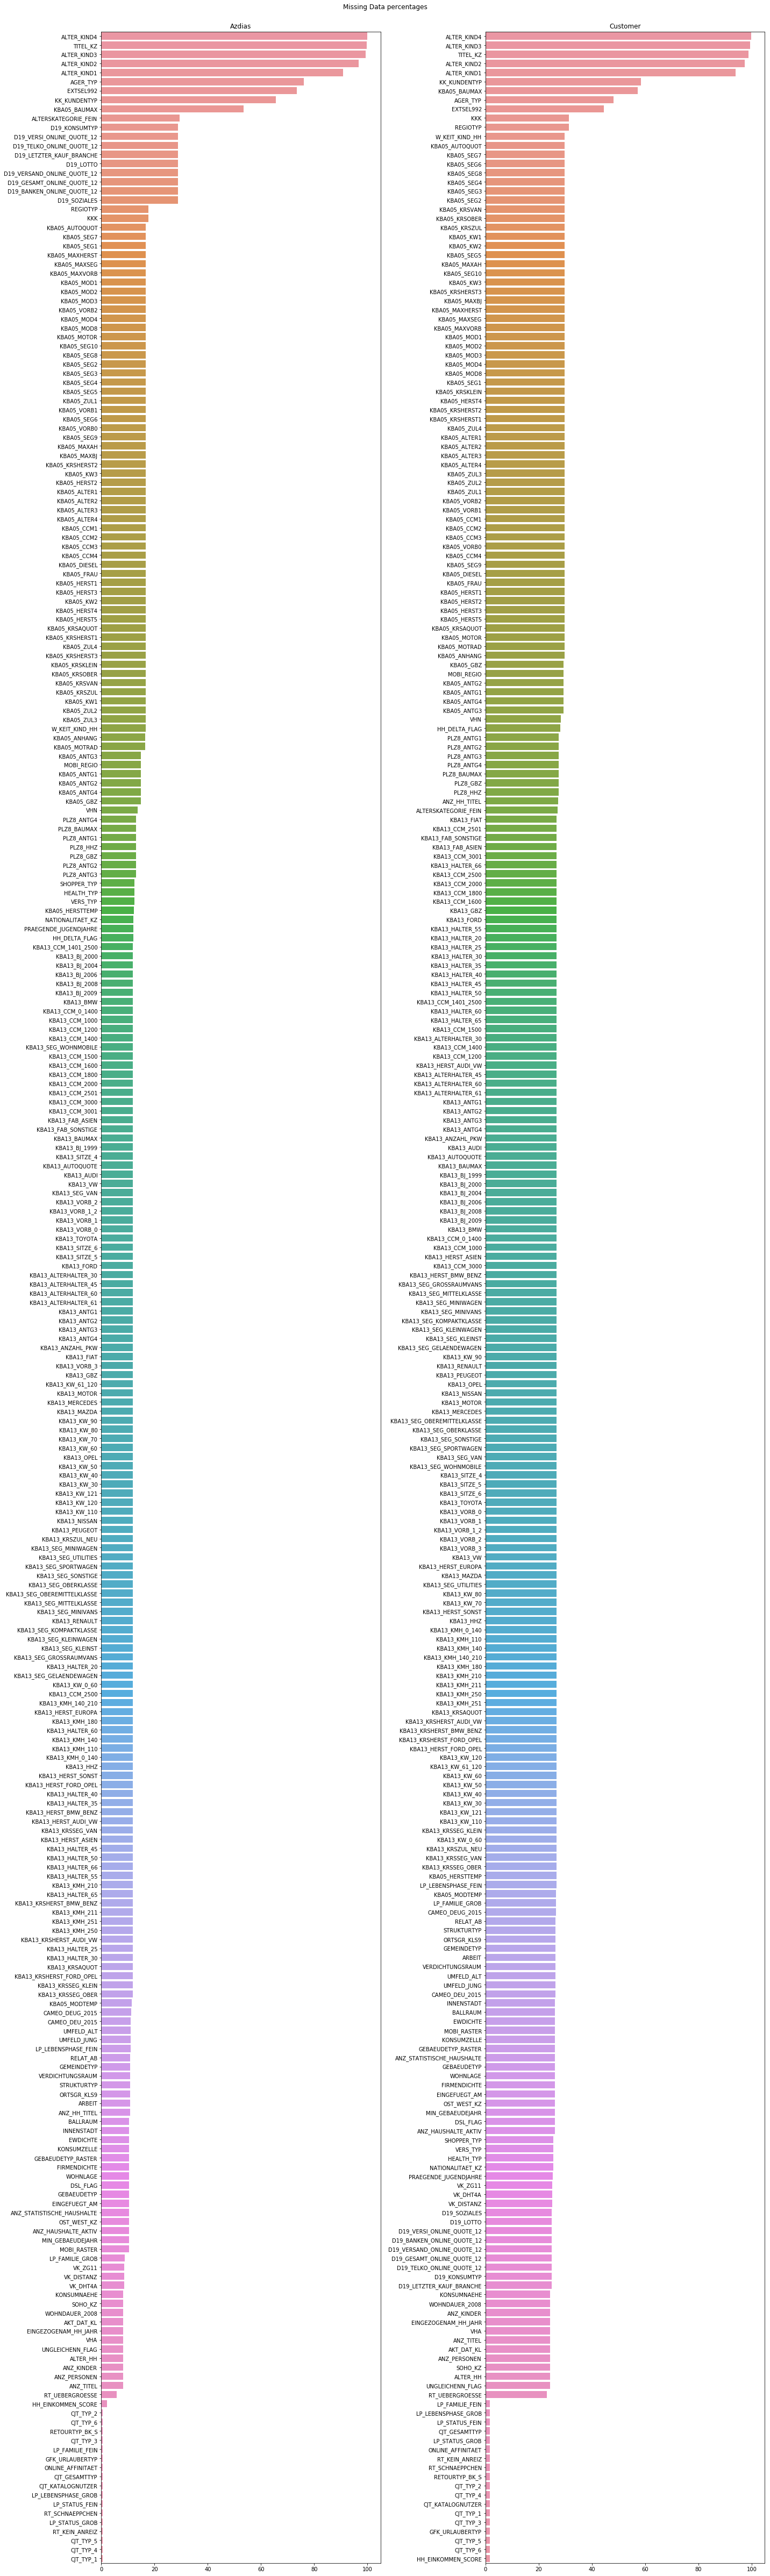

In [44]:
fig = plt.figure(figsize=(20, 70))
fig.suptitle("Missing Data percentages")

ax = fig.add_subplot(121)
ax.set_title("Azdias")
sns.barplot(azdias_missing.values, azdias_missing.index, ax= ax)

ax = fig.add_subplot(122)
ax.set_title("Customer")
sns.barplot(customer_missing.values, customer_missing.index, ax= ax)

fig.tight_layout(rect=[0, 0.03, 1, 0.975])
plt.show()

- By looking at the plot above we can conclude what percentage of data is missing from each column where we have missing data.
- Also the percentage of missing values in Azdias and Customers coincide a lot, which confirms that customers data is a subset of azdias data.

For here, we need remove those columns with more than half missing data, it is hard to impute and will intereface our further analysis.

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


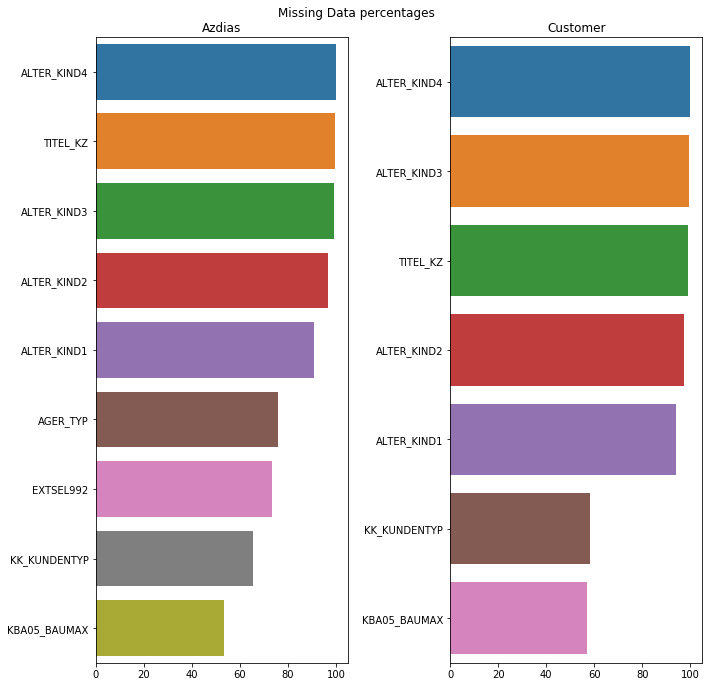

In [45]:
#Plot with Columns plan to remove
azdias_missing_re = azdias_missing[azdias_missing.values >= 50]
customer_missing_re = customer_missing[customer_missing.values >= 50]
fig = plt.figure(figsize=(10, 10))
fig.suptitle("Missing Data percentages")

ax = fig.add_subplot(121)
ax.set_title("Azdias")
sns.barplot(azdias_missing_re.values, azdias_missing_re.index, ax= ax)

ax = fig.add_subplot(122)
ax.set_title("Customer")
sns.barplot(customer_missing_re.values, customer_missing_re.index, ax= ax)

fig.tight_layout(rect=[0, 0.03, 1, 0.975])
plt.show()

In [46]:
#sync Azdias and Customers columns to remove
remove_list = list(customer_missing_re.index) + ['KBA05_ANTG3']
azdias= azdias.drop(remove_list, axis = 1)
customers = customers.drop(remove_list, axis = 1)

In [47]:
azdias.shape, customers.shape

((891221, 358), (191652, 361))

#### Rows with Missing Value

After removing the columns which have more than 50% missing values, now we can look at the dataframes with remaining features for any missing values in rows. If one record missing most of feature informations, will be useless to keep this records.

In [48]:
row_missing_a = azdias.isnull().sum(axis = 1)
row_missing_c = customers.isnull().sum(axis=1)

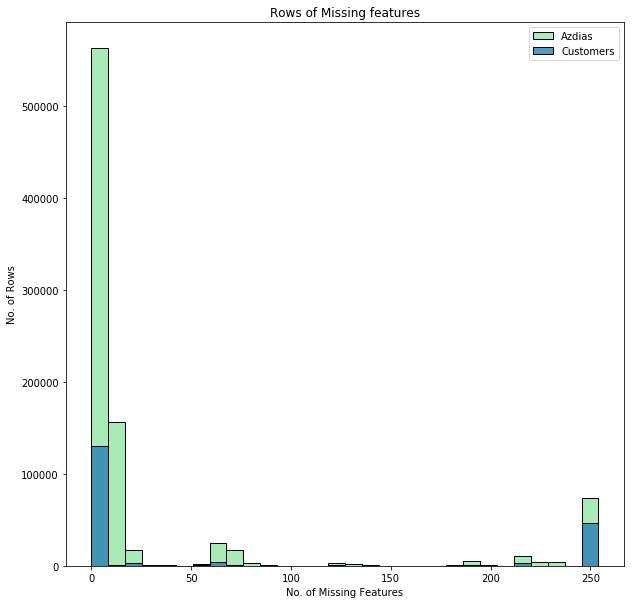

In [49]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
ax.set_title("Rows of Missing features")
ax.set_xlabel("No. of Missing Features")
ax.set_ylabel("No. of Rows")
base_color = sns.color_palette("pastel")[2]
sns.histplot(row_missing_a, bins = 30, ax=ax, color= base_color,label="Azdias")
sns.histplot(row_missing_c, bins= 30, ax=ax, label="Customers")
ax.legend()
    
plt.show()


From above graph, we can conclude remove row with missing more than 50 features would be appriopriate

In [50]:
azdias = azdias.dropna(thresh = azdias.shape[1] - 50)
customers = customers.dropna(thresh = customers.shape[1] - 50)

In [51]:
azdias.shape, customers.shape

((737288, 358), (134246, 361))

#### Columns Type Check

In [52]:
azdias.info(), customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737288 entries, 1 to 891220
Columns: 358 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(266), int64(88), object(4)
memory usage: 2.0+ GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 134246 entries, 0 to 191651
Columns: 361 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(266), int64(89), object(6)
memory usage: 370.8+ MB


(None, None)

In [53]:
azdias_object_cols = azdias.columns[azdias.dtypes == "object"]
customer_object_cols = customers.columns[customers.dtypes == "object"]
azdias_object_cols, customer_object_cols

(Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM',
        'OST_WEST_KZ'],
       dtype='object'),
 Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM',
        'OST_WEST_KZ', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
       dtype='object'))

- D19_LETZTER_KAUF_BRANCHE - contains information about the last branch they made a purchase.
- CAMEO_DEU_2015 - Gives information about specific group a person belongs to.
- OST_WEST_KZ - contains information about the history of the person i.e. which part of Germany they belonged to before unification

Above 3 columns include too much details, increase dimension of our analysis, would not be good features for our clustering and prediction, so will remove them here.

In [54]:
azdias = azdias.drop(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], axis = 1)
customers = customers.drop(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], axis = 1)

In [55]:
#update EINGEFUEGT_AM to date type
azdias["EINGEFUEGT_AM"] = pd.to_datetime(azdias["EINGEFUEGT_AM"])
azdias["EINGEFUEGT_AM"] = azdias['EINGEFUEGT_AM'].map(lambda x: x.year)
customers["EINGEFUEGT_AM"] = pd.to_datetime(customers["EINGEFUEGT_AM"])
customers["EINGEFUEGT_AM"] = customers['EINGEFUEGT_AM'].map(lambda x: x.year)  

#### Impute Missing Value

As for we used demographic data here, used most frequency data to fill missing part should make sense, but still need to be care about bias lead to.

In [56]:
imputer = SimpleImputer(strategy="most_frequent")

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.fit_transform(customers), columns = customers.columns)

In [57]:
azdias.shape, customers.shape

((737288, 355), (134246, 358))

### 0.2.3 Feature engineering

In [58]:
customers.groupby(['PRODUCT_GROUP'])['PRODUCT_GROUP'].count()
customers.groupby(['CUSTOMER_GROUP'])['CUSTOMER_GROUP'].count()

CUSTOMER_GROUP
MULTI_BUYER     94544
SINGLE_BUYER    39702
Name: CUSTOMER_GROUP, dtype: int64

In [59]:
customers['PRODUCT_GROUP'] = customers['PRODUCT_GROUP'].replace({'COSMETIC': 1, 'FOOD': 2, 'COSMETIC_AND_FOOD' : 3})
customers['PRODUCT_GROUP'] = customers['PRODUCT_GROUP'].astype(int)

customers['CUSTOMER_GROUP'] = customers['CUSTOMER_GROUP'].replace({'SINGLE_BUYER': 1, 'MULTI_BUYER': 2})
customers['CUSTOMER_GROUP'] = customers['CUSTOMER_GROUP'].astype(int)

#### feature scaling

In [60]:
scaler = StandardScaler()

scaler.fit(azdias)
azdias = pd.DataFrame(scaler.transform(azdias), columns = azdias.columns)

scaler.fit(customers)
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  import sys


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Dimensionality reduction - PCA algorithm

In [61]:
def perform_pca(data, n_components=None):
    """
    Input: to be fitted data, components needs to keep
    Output PCA models
    Description: create PCA model to fit on corresponding data
    
    """   
    pca = PCA(n_components)
    pca.fit(data)
    data_transformed = pca.transform(data)
    return pca, data_transformed


In [62]:
pca, azdias_pca = perform_pca(azdias)

In [63]:
def pca_variance_plot(pca, importance = True):
    '''
    Input: PCA model, plot to draw
    Output: pca variance related plot
    Description: plot Cummulative Variance graph and Each Variance Ratio graph
    '''
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(211)
    # if importance, then plot each variance, else plot cummulated variance 
    if importance == True:
        # each variance importance
        per_var = pca.explained_variance_ratio_
        y_label = "Percentage Variance Ratio"
        ax.plot(per_var)
        values = range(0, 351, 5)
        plt.xticks(values)
    else:
        #cummulated importance
        azdias_variance = np.cumsum(pca.explained_variance_ratio_)
        y_label = "Cummulative Explained Variance"
        ax.plot(azdias_variance)
          
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("Azdias - PCA Explained Variance Ratio")
    ax.grid()
    plt.show()

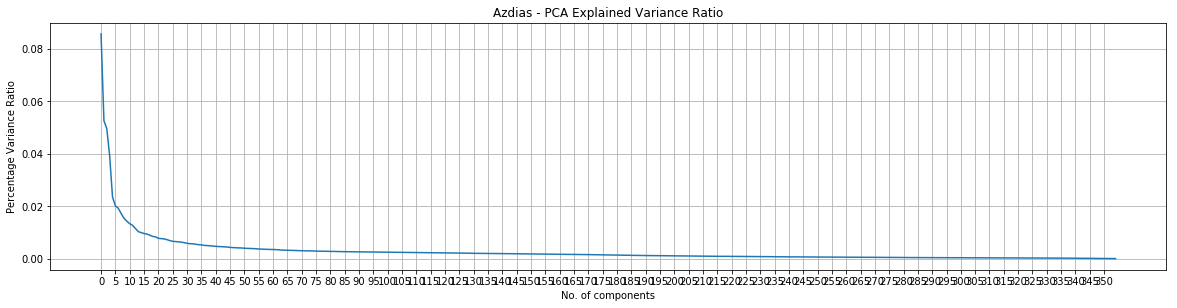

In [64]:
pca_variance_plot(pca, True)

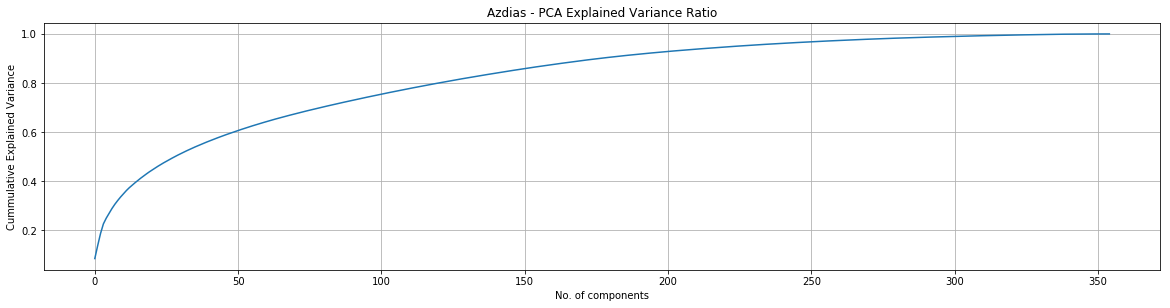

In [65]:
pca_variance_plot(pca, False)

From above second graph, we can find 150 components explain 90% of variance in the dataset. So we can set the number of components to 150 and perform PCA analysis.  And from above first graph, we can find Components effect dramaticly decrease since component 5. So next step, we can see the feature importances base on first 5 components.

In [66]:
pca, azdias_pca = perform_pca(azdias, 150)

In [67]:
#draw feature weighs in each component
def plot_feature_weight(df, pca, attributes_info, dimension, top_feature, plot = True):
    '''
    Input: df: correspodent dataset, pca: pca model, attributes_info: dataset to get description:
           dimension: which PCA dimension to see, top_feature: see how many features each time
    Output: feature and matched weight dataframe
    Description: Process to get feature and matched weight dataframe for each PCA component and plot it
    '''
    #feature name
    feature = df.columns.values
    #get each feature in each components weight
    components = pca.components_
    #match feature and component weight
    feature_weights = dict(zip(feature, components[dimension]))
    # descend with absolute value of weight
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: abs(kv[1]), reverse =True)
    
    features = []
    weights = []
    descs = []

    for feature, weight in sorted_weights[:top_feature]:
        features.append(feature)
        weights.append(weight)
        
    # get description for each feature, to help later PAC explain
    for feature in features:
        if feature in attributes_info.Attribute.values:
            descs.append(attributes_info[attributes_info.Attribute == feature].Description.values[0])
        else:
            descs.append("No description given")
           
    component_info = {"Feature":features, "Description":descs, "FeatureWeight":weights}
    component_info = pd.DataFrame(component_info)
    
    # plot on selected component
    if plot:
        fig = plt.figure(figsize=(10, 10))

        ax = fig.add_subplot(211)
        #x: feature, y: feature weight in this component, how importance it is in this component
        ax.bar(features, weights, data = component_info)
        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension + 1))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.grid()

        fig.tight_layout()
        plt.show()
    
        
    return component_info

#### PCA1
Has some features have no description given, but base on some similar features (which have a description), we can find these features should correspond to shares of cars with some specification.

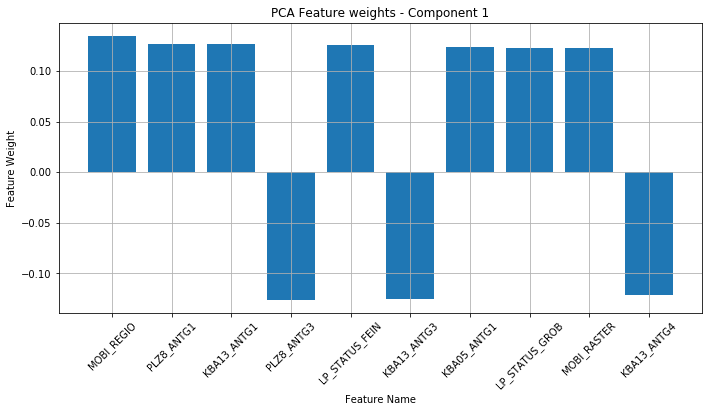

In [68]:
PCA1 = plot_feature_weight(azdias, pca, attribuets_desc, 0, 10, plot = True)

In [69]:
PCA1

,Feature,Description,FeatureWeight
0,MOBI_REGIO,moving patterns,0.134613
1,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0.127133
2,KBA13_ANTG1,No description given,0.126542
3,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.126047
4,LP_STATUS_FEIN,social status fine,0.125501
5,KBA13_ANTG3,No description given,-0.125409
6,KBA05_ANTG1,number of 1-2 family houses in the cell,0.124261
7,LP_STATUS_GROB,social status rough,0.123100
8,MOBI_RASTER,No description given,0.122465
9,KBA13_ANTG4,No description given,-0.121745


#### PCA2
Has a high positive weights towards features that have information about car's type.

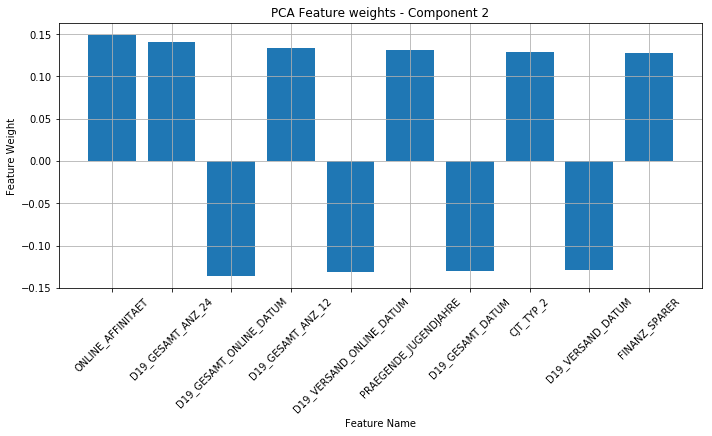

In [70]:
PCA2 = plot_feature_weight(azdias, pca, attribuets_desc, 1, 10, plot = True)

In [71]:
PCA2

,Feature,Description,FeatureWeight
0,ONLINE_AFFINITAET,online affinity,0.149144
1,D19_GESAMT_ANZ_24,No description given,0.140984
2,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,-0.136485
3,D19_GESAMT_ANZ_12,No description given,0.133080
4,D19_VERSAND_ONLINE_DATUM,actuality of the last transaction for the segm...,-0.131604
5,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,0.131351
6,D19_GESAMT_DATUM,actuality of the last transaction with the com...,-0.130473
7,CJT_TYP_2,No description given,0.129340
8,D19_VERSAND_DATUM,actuality of the last transaction for the segm...,-0.128430
9,FINANZ_SPARER,financial typology: money saver,0.128264


#### PCA3
- This component show a high related with People finanial situation
- This component positive corresponds to people who are always financially prepared.
- This component show a high weights towards features that car's CJT type

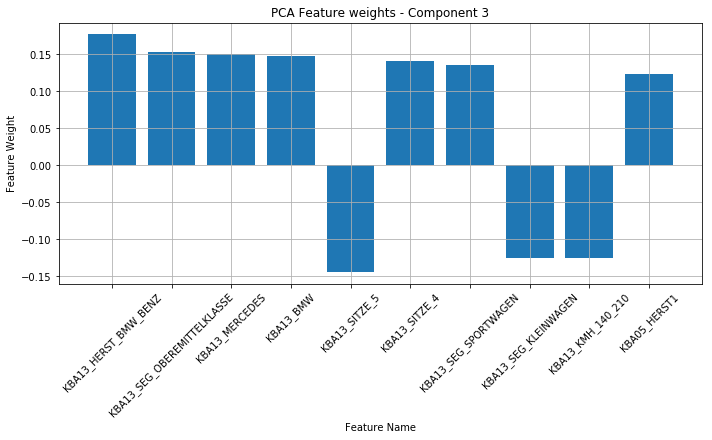

In [72]:
PCA3 = plot_feature_weight(azdias, pca, attribuets_desc, 2, 10, plot = True)

In [73]:
PCA3

,Feature,Description,FeatureWeight
0,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.176241
1,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper cla...,0.152189
2,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.149876
3,KBA13_BMW,share of BMW within the PLZ8,0.147825
4,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.143941
5,KBA13_SITZE_4,number of cars with less than 5 seats in the PLZ8,0.140789
6,KBA13_SEG_SPORTWAGEN,share of sportscars within the PLZ8,0.135089
7,KBA13_SEG_KLEINWAGEN,share of small and very small cars (Ford Fiest...,-0.125603
8,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,-0.124792
9,KBA05_HERST1,"share of top German manufacturer (Mercedes, BMW)",0.122561


#### PCA4
Has a high negative weights towards features that have information about Upper class car's shares.

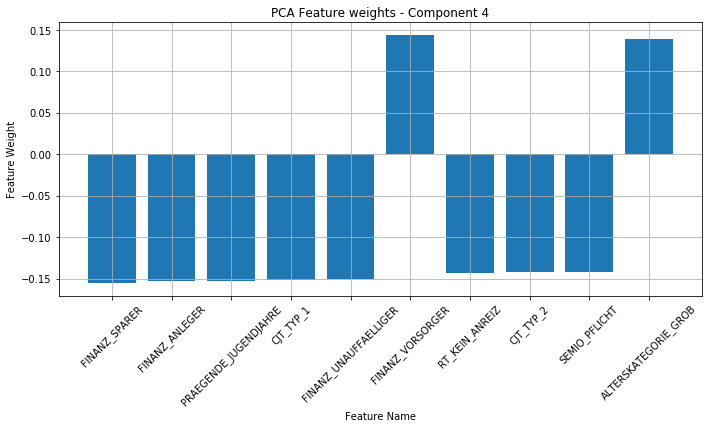

In [74]:
PCA4 = plot_feature_weight(azdias, pca, attribuets_desc, 3, 10, plot = True)

In [75]:
PCA4

,Feature,Description,FeatureWeight
0,FINANZ_SPARER,financial typology: money saver,-0.155624
1,FINANZ_ANLEGER,financial typology: investor,-0.153419
2,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,-0.153022
3,CJT_TYP_1,No description given,-0.152047
4,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,-0.150859
5,FINANZ_VORSORGER,financial typology: be prepared,0.143862
6,RT_KEIN_ANREIZ,No description given,-0.142947
7,CJT_TYP_2,No description given,-0.142569
8,SEMIO_PFLICHT,affinity indicating in what way the person is ...,-0.142057
9,ALTERSKATEGORIE_GROB,age through prename analysis,0.138339


#### PCA5
- People with share of cars with less engine power and ccm has high negative weight 
- People with share of cars with more engine power has high positive weight

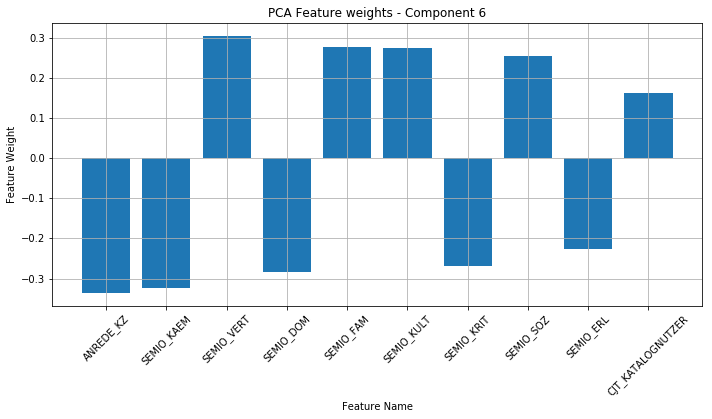

In [76]:
PCA5 = plot_feature_weight(azdias, pca, attribuets_desc, 5, 10, plot = True)

In [77]:
PCA5

,Feature,Description,FeatureWeight
0,ANREDE_KZ,gender,-0.336688
1,SEMIO_KAEM,affinity indicating in what way the person is ...,-0.324779
2,SEMIO_VERT,affinity indicating in what way the person is ...,0.304857
3,SEMIO_DOM,affinity indicating in what way the person is ...,-0.283447
4,SEMIO_FAM,affinity indicating in what way the person is ...,0.277512
5,SEMIO_KULT,affinity indicating in what way the person is ...,0.275148
6,SEMIO_KRIT,affinity indicating in what way the person is ...,-0.268065
7,SEMIO_SOZ,affinity indicating in what way the person is ...,0.253775
8,SEMIO_ERL,affinity indicating in what way the person is ...,-0.227183
9,CJT_KATALOGNUTZER,No description given,0.162208


From above 5 components, we found the features related to car and finance basically have impact on each components, they will be importance in our next step analysis.

As for dataframe customers is subset of azdias, so we will default they use the same PCA reduction model.

### 1.2 Customer Segmentation - K-Means Clustering

In [78]:
#After reducing the number of dimensions, we will now use the K-Means Clustering algorithm to cluster the general population into different segments.
def K_Mean_Clustering(data, n_clusters, interval):
    # save score for different cluster divided
    scores = []
    for n in range(2, n_clusters, 1):
        #kmean model apply
        kmeans = KMeans(n)
        model = kmeans.fit(data)
        score = model.score(data)
        # get absolute score to easy plot
        scores.append(abs(score))
        print('n_clusters: ' + str(n) + ' | Score: ' + str(score))
    return scores

In [79]:
scores = K_Mean_Clustering(azdias_pca, 11, 1)

n_clusters: 2 | Score: -207975598.16942102
n_clusters: 3 | Score: -200162150.29851234
n_clusters: 4 | Score: -195867604.46852192
n_clusters: 5 | Score: -192284572.19495198
n_clusters: 6 | Score: -189224025.9162396
n_clusters: 7 | Score: -186898128.3603494
n_clusters: 8 | Score: -184813958.4692307
n_clusters: 9 | Score: -183108863.12381035
n_clusters: 10 | Score: -181743378.21364048


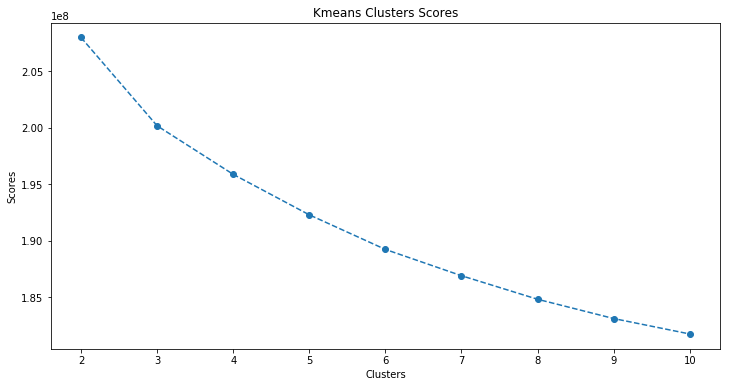

In [82]:
#plot to see the relationship trendency between clusters and scores
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
    
ax.plot(range(2, 11, 1), scores, linestyle= "--",marker = "o")
ax.set_xticks(range(2, 11, 1))
ax.set_xlabel("Clusters")
ax.set_ylabel("Scores")
ax.set_title("Kmeans Clusters Scores")
    
plt.show()

To select the best number of clusters, we can select n_clusetrs with minimize the intra-cluster variation. From Above elbow graph, we can find sum of sqaured error dramaticly decreasing stop at 6 clusters, then with relative smooth slope, so here we decided to use 6 clusters.

In [83]:
kmeans = KMeans(6)
kmeans.fit(azdias_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [84]:
azdias_clusters = kmeans.predict(azdias_pca)

In [85]:
azdias_clusters

array([0, 0, 5, ..., 0, 3, 5], dtype=int32)

In [86]:
pca, customers_pca = perform_pca(customers, 150)
kmeans.fit(customers_pca)
customers_clusters = kmeans.predict(customers_pca)

In [87]:
customers_clusters

array([2, 0, 3, ..., 2, 0, 3], dtype=int32)

To view the distribution of each cluster, we plot base on a 2 dimensions and as for 6 clusters might be chaso in one graph, we split to 6 plots and compare with each other base on X-axis and Y-axis

In [88]:
azdias_cluster = azdias
azdias_cluster['cluster'] = azdias_clusters
azdias_cluster['X'] = azdias_pca[:, 0]
azdias_cluster['Y'] = azdias_pca[:, 1]

In [89]:
customer_cluster = customers
customer_cluster['cluster'] = customers_clusters
customer_cluster['X'] = customers_pca[:, 0]
customer_cluster['Y'] = customers_pca[:, 1]

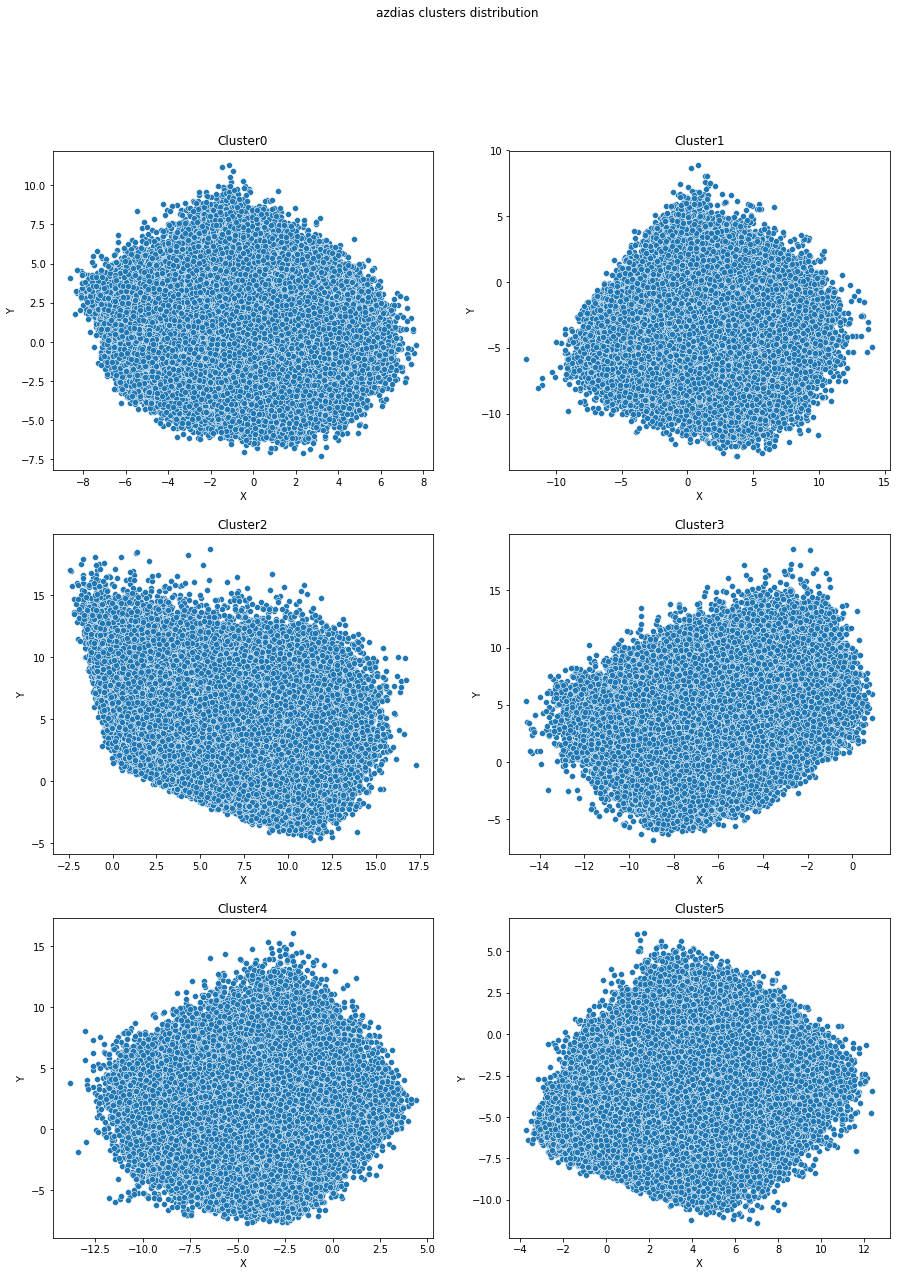

In [99]:
#azdias clusters distribution plot
plt.figure(figsize=(15,20)).suptitle("azdias clusters distribution")
for i in range(0,6):
    tmp = azdias_cluster[azdias_cluster['cluster'] == i]
    plt.subplot(3,2, i+1)   
    sns.scatterplot( y= 'Y', 
                     x= 'X', 
                     data= tmp).set(title= 'Cluster' + str(i))

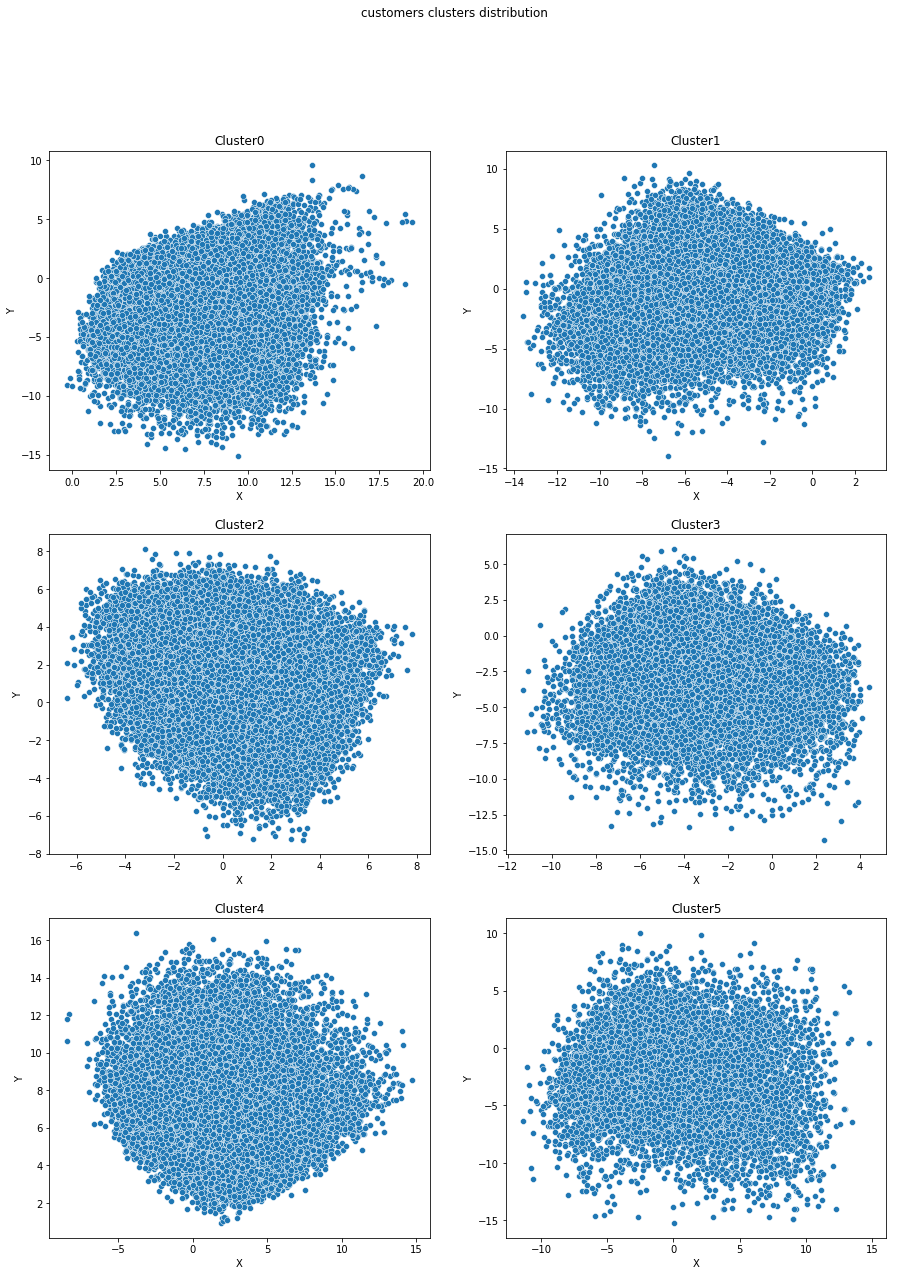

In [100]:
#customers clusters distribution plot
plt.figure(figsize=(15,20)).suptitle("customers clusters distribution")
for i in range(0,6):
    tmp = customer_cluster[customer_cluster['cluster'] == i]
    plt.subplot(3,2, i+1)   
    sns.scatterplot( y= 'Y', 
                     x= 'X', 
                     data= tmp).set(title= 'Cluster' + str(i))

from above 2 group plots, we found :
- each cluster of azdias and customers data has similar distribution tendency

In [116]:
#The Number of people coming under each cluster can be stored in a dataframe for further analysis.
cluster_info = pd.DataFrame([])

azdias_clusters_info = pd.Series(azdias_clusters)
customers_clusters_info = pd.Series(customers_clusters)
cluster_info["Population"] = azdias_clusters_info.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters_info.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

cluster_info

,Cluster,Population,Customers
0,0,134657,22988
1,1,93546,26384
2,2,145088,33281
3,3,119716,22351
4,4,110707,17667
5,5,133574,11575


In [118]:
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)
cluster_info["Cust_over_Pop"] = cluster_info["Cust_proportion"] / cluster_info["Pop_proportion"]

In [121]:
cluster_info

,Cluster,Population,Customers,Pop_proportion,Cust_proportion,Cust_over_Pop
0,0,134657,22988,18.26,17.12,0.937568
1,1,93546,26384,12.69,19.65,1.548463
2,2,145088,33281,19.68,24.79,1.259654
3,3,119716,22351,16.24,16.65,1.025246
4,4,110707,17667,15.02,13.16,0.876165
5,5,133574,11575,18.12,8.62,0.475717


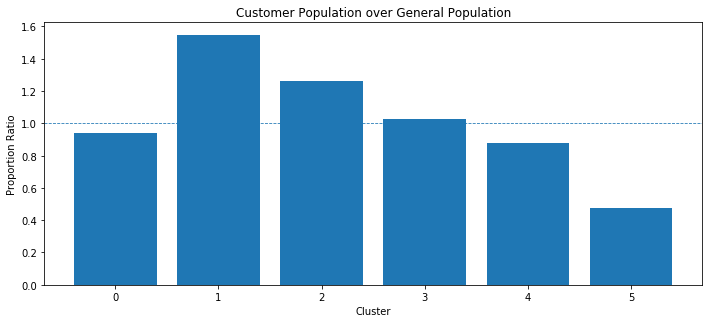

In [124]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

ax.bar(cluster_info["Cluster"], cluster_info["Cust_over_Pop"])
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("Customer Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The ratio > 1 indicates that the cluster contains more customers, and there is a scope of the people belonging to these clusters being future customers.

The ratio between proportions of customers and population gave an idea about what proportion of customers are there in each cluster.
This also gives an idea about which cluster can be targetted for future customers.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [27]:
mailout_train = pd.read_csv('/Users/ante/Desktop/DataScienstCourse/mailout_train.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [29]:
mailout_train.shape

(42962, 368)

### 2.1 Cleaning Data

In [31]:
Col_ToCheck_M = list(set(mailout_train.columns)& set(attribute_list))
List_With_Invalid_M = Col_With_Invalid(mailout_train, Col_ToCheck_M)

CAMEO_DEU_2015 '<' not supported between instances of 'float' and 'str'
CAMEO_DEUG_2015 '<' not supported between instances of 'str' and 'float'
OST_WEST_KZ '<' not supported between instances of 'float' and 'str'


In [32]:
#with general values in Attribute
General_Value = []
for key in List_With_Invalid_M.keys():
    if(len(List_With_Invalid_M[key]) > 5):
        General_Value.append(key)
for value in General_Value:
    List_With_Invalid_M.pop(value)

In [33]:
List_With_Invalid_M

{'KBA05_ZUL3': ['9.0', 'nan'],
 'KBA05_SEG6': ['9.0', 'nan'],
 'KBA05_DIESEL': ['9.0', 'nan'],
 'KBA05_KRSZUL': ['9.0', 'nan'],
 'KBA05_MOD8': ['9.0', 'nan'],
 'KBA05_AUTOQUOT': ['9.0', 'nan'],
 'KBA05_MOD4': ['9.0', 'nan'],
 'KBA05_HERST5': ['9.0', 'nan'],
 'ANZ_TITEL': ['0.0', '1.0', '2.0', 'nan'],
 'KBA05_KRSOBER': ['9.0', 'nan'],
 'PRAEGENDE_JUGENDJAHRE': ['0'],
 'KBA05_VORB0': ['9.0', 'nan'],
 'LP_FAMILIE_FEIN': [0.0],
 'KBA05_MAXBJ': ['9.0', 'nan'],
 'KBA05_KRSHERST1': ['9.0', 'nan'],
 'KBA05_SEG8': ['9.0', 'nan'],
 'KBA05_KRSVAN': ['9.0', 'nan'],
 'KBA05_MOTOR': ['9.0', 'nan'],
 'KBA05_HERST1': ['9.0', 'nan'],
 'KBA05_VORB1': ['9.0', 'nan'],
 'REGIOTYP': ['0.0', 'nan'],
 'KBA05_KW2': ['9.0', 'nan'],
 'KBA05_CCM4': ['9.0', 'nan'],
 'KBA05_HERST3': ['9.0', 'nan'],
 'KBA05_VORB2': ['9.0', 'nan'],
 'LP_FAMILIE_GROB': [0.0],
 'KKK': ['0.0', 'nan'],
 'KBA05_GBZ': ['nan'],
 'KBA05_ALTER4': ['9.0', 'nan'],
 'KBA05_CCM1': ['9.0', 'nan'],
 'KBA05_CCM2': ['9.0', 'nan'],
 'HH_EINKOMMEN_SCOR

In [34]:
mailout_train['LP_LEBENSPHASE_FEIN'] = mailout_train['LP_LEBENSPHASE_FEIN'].replace({0: np.nan})
mailout_train['LP_FAMILIE_GROB'] = mailout_train['LP_FAMILIE_GROB'].replace({0: np.nan})
mailout_train['KBA05_MODTEMP'] = mailout_train['KBA05_MODTEMP'].replace({6: np.nan})
mailout_train['ANZ_TITEL'] = mailout_train['ANZ_TITEL'].replace({0: np.nan, 1:np.nan, 2:np.nan})

In [37]:
mailout_train = replace_unkowns(mailout_train, unkown_attributes_values)

In [38]:
mailout_train_missing = (mailout_train.isnull().sum()*100/ mailout_train.shape[0]).sort_values(ascending = False)
mailout_train_missing = mailout_train_missing[mailout_train_missing.values != 0]

In [39]:
mailout_train_missing_re = mailout_train_missing[mailout_train_missing.values >= 50]
remove_list = list(mailout_train_missing_re.index)
mailout_train = mailout_train.drop(remove_list, axis = 1)

In [40]:
mailout_train = mailout_train.dropna(thresh = mailout_train.shape[1] - 50)

In [41]:
mailout_train.shape, mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33837 entries, 0 to 42961
Columns: 360 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(265), int64(89), object(6)
memory usage: 93.2+ MB


((33837, 360), None)

In [42]:
mailout_train.columns[mailout_train.dtypes == "object"]

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [43]:
mailout_train = mailout_train.drop(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], axis = 1)

In [44]:
mailout_train["EINGEFUEGT_AM"] = pd.to_datetime(mailout_train["EINGEFUEGT_AM"])
mailout_train["EINGEFUEGT_AM"] = mailout_train['EINGEFUEGT_AM'].map(lambda x: x.year)

In [45]:
imputer = SimpleImputer(strategy="most_frequent")
mailout_train = pd.DataFrame(imputer.fit_transform(mailout_train), columns = mailout_train.columns)

In [46]:
mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.0,1763.0,2.0,1.0,8.0,8.0,15.0,0.0,0.0,1.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3.0,0.0,2.0,4.0
1,1.0,1771.0,1.0,4.0,13.0,13.0,1.0,0.0,0.0,2.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1.0,0.0,2.0,3.0
2,2.0,1776.0,1.0,1.0,9.0,7.0,0.0,0.0,0.0,0.0,...,6.0,4.0,2.0,6.0,9.0,2.0,3.0,0.0,1.0,4.0
3,3.0,1460.0,2.0,1.0,6.0,6.0,4.0,0.0,0.0,2.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3.0,0.0,2.0,4.0
4,4.0,1783.0,2.0,1.0,9.0,9.0,53.0,0.0,0.0,1.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3.0,0.0,1.0,3.0


In [47]:
mailout_train.shape

(33837, 355)

### 2.2 Setting the benchmark

#### 2.2.1 Evaluation metrics

In [48]:
print(mailout_train.RESPONSE.value_counts())

0.0    33421
1.0      416
Name: RESPONSE, dtype: int64


Because the MAILOUT_TRAIN data set is very unbalanced, simple accuracy evaluation just does not fit for this problem. Even if my model labels everythong as 0 it will have high accuracy, while it is actually not quite true.
As for ROC is able to handle with the true positive rate and the false positive rate, which is quite essential for this particular task.
So I have decided to choose the ROC evaluation metric.


#### 2.2.2 Training a Logistic regression model on unscaled data

In [49]:
X = mailout_train.drop(['RESPONSE'], axis = 1)
Y = mailout_train['RESPONSE']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


In [51]:
lr = LogisticRegression(random_state=0)

In [52]:
lr.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [53]:
y_pred = lr.predict_proba(X_test)[:,1]

In [54]:
print("Baseline AUROC - ", roc_auc_score(y_test, y_pred))

Baseline AUROC -  0.7782946747229681


### 2.3 Improve Model Performance

#### 2.3.1 Next we are going to try different models and see if other models can improve this score and which model perform best

In [59]:
X = mailout_train.drop(['RESPONSE'], axis = 1)
Y = mailout_train['RESPONSE']

In [60]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


In [322]:
models = [("LogisticRegression", LogisticRegression(random_state=0)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=0)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=0)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=0)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=0)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=0))]

In [323]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    model = model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_test)[:,1]
    
    roc_score = roc_auc_score(y_test, y_pred)
    
    print(str(model) + ': done')
    
    return roc_score

In [324]:
results = {"Model":[],
          "AUCROC_score":[]}

for name, model in models:
    roc = train_and_predict(model, X_train, y_train, X_test, y_test)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False): done
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'): done


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False): done
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False): done
AdaBoostClassifier(algorithm='SAMME.R

In [325]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score
0,LogisticRegression,0.754542
1,DecisionTreeClassifier,0.497859
2,RandomForestClassifier,0.546124
3,GradientBoostingClassifier,0.799063
4,AdaBoostClassifier,0.785978
5,XGBClassifier,0.804544


#### 2.3.2 We can also try reducing number of dimensions to see whether that helps to improve performance

In [326]:
pca, X_pca = perform_pca(X, 150)

In [327]:
X_reduce = pca.transform(X)

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduce, Y, test_size=0.2, random_state=0)

In [328]:
models = [("LogisticRegression", LogisticRegression(random_state=0)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=0)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=0)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=0)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=0)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=0))]

results = {"Model":[],
          "AUCROC_score":[]}

for name, model in models:
    roc = train_and_predict(model, X_train_red, y_train_red, X_test_red, y_test_red)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False): done
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'): done


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False): done
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False): done
AdaBoostClassifier(algorithm='SAMME.R

In [329]:
results_PCA = pd.DataFrame.from_dict(results, orient='index').transpose()
results_PCA

,Model,AUCROC_score
0,LogisticRegression,0.791668
1,DecisionTreeClassifier,0.492011
2,RandomForestClassifier,0.493803
3,GradientBoostingClassifier,0.64488
4,AdaBoostClassifier,0.623273
5,XGBClassifier,0.66969


The dimensionality reduction seems to not help here. We will continue with the data with all the columns.

#### 2.3.3 We can use cross validation to measure our models general performance, to make sure accuracy

In [330]:
def train_and_predict_cv(model, X, Y):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test  with cross validation 
    Calculate AUROC on predictions made on test data
    
    Outputs - average AUROC score, time elapse for training and prediction    
    """
    scores = cross_val_score(model, X, Y, cv=5)
    
    score = sum(scores)/len(scores)
    
    print(str(model) + ': done')
    
    return score

In [331]:
results = {"Model":[],
          "cv_score":[]}

for name, model in models:
    cv = train_and_predict_cv(model, X, Y)
    results["Model"].append(name)
    results["cv_score"].append(cv)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False): done
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'): done
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, 

In [332]:
results_cv = pd.DataFrame.from_dict(results, orient='index').transpose()
results_cv

,Model,cv_score
0,LogisticRegression,0.987588
1,DecisionTreeClassifier,0.964951
2,RandomForestClassifier,0.987706
3,GradientBoostingClassifier,0.987351
4,AdaBoostClassifier,0.987765
5,XGBClassifier,0.987706


### Hyperparameter tuning - Apply Grid Search to best performance model

#### XGBClassifier

In [73]:
xgb_param_grid = {"max_depth": [5,10],
              "learning_rate": [0.01,0.1],
              "gamma":[0.1,0.5],
              "n_estimators":[50,100]
              }

xgb_grid = GridSearchCV(estimator = xgb.XGBClassifier(objective="binary:logistic", 
                                                            n_jobs=-1, eval_metric="auc",
                                                            silent=1,random_state=0), 
                           param_grid = xgb_param_grid, 
                           scoring = "roc_auc",
                           cv = 2, n_jobs = -1, verbose=2)

In [74]:
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  5.3min finished


In [75]:
print("Best Score: ", xgb_grid.best_score_)
print("Best Params: ", xgb_grid.best_params_)

Best Score:  0.7680850228302155
Best Params:  {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


In [76]:
preds_xgb = best_xgb.predict_proba(X_test)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_test, preds_xgb)))

ROC score on validation data: 0.7953


As for computer performance limitation, we limited the test with Hyperparameter tuning, so it did not work well, in current condition, will not take it to do prediction, but if have a change will improve it.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [333]:
mailout_test = pd.read_csv('/Users/ante/Desktop/DataScienstCourse/mailout_test.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [334]:
mailout_test.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


#### clean data

In [335]:
mailout_test['LP_LEBENSPHASE_FEIN'] = mailout_test['LP_LEBENSPHASE_FEIN'].replace({0: np.nan})
mailout_test['LP_FAMILIE_GROB'] = mailout_test['LP_FAMILIE_GROB'].replace({0: np.nan})
mailout_test['KBA05_MODTEMP'] = mailout_test['KBA05_MODTEMP'].replace({6: np.nan})
mailout_test['ANZ_TITEL'] = mailout_test['ANZ_TITEL'].replace({0: np.nan, 1:np.nan, 2:np.nan})
mailout_test = replace_unkowns(mailout_test, unkown_attributes_values)
mailout_test = mailout_test.drop(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], axis = 1)
mailout_test["EINGEFUEGT_AM"] = pd.to_datetime(mailout_test["EINGEFUEGT_AM"])
mailout_test["EINGEFUEGT_AM"] = mailout_test['EINGEFUEGT_AM'].map(lambda x: x.year)

In [336]:
mailout_test_missing = (mailout_test.isnull().sum()*100/ mailout_test.shape[0]).sort_values(ascending = False)
mailout_test_missing = mailout_test_missing[mailout_test_missing.values != 0]
mailout_test_missing_re = mailout_test_missing[mailout_test_missing.values >= 50]
remove_list = list(mailout_test_missing_re.index)
mailout_test = mailout_test.drop(remove_list, axis = 1)
mailout_test = mailout_test.dropna(thresh = mailout_test.shape[1] - 50)

In [337]:
imputer = SimpleImputer(strategy="most_frequent")
mailout_test = pd.DataFrame(imputer.fit_transform(mailout_test), columns = mailout_test.columns)

In [343]:
X = mailout_train.drop(['RESPONSE'], axis = 1)
Y = mailout_train['RESPONSE']
best_xgboost = xgb.XGBClassifier(random_state=0)
best_xgboost.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [344]:
mailout_test_LNR = mailout_test["LNR"]

In [345]:
preds_test_xgboost = best_xgboost.predict_proba(mailout_test)[:,1]

In [346]:
kaggle_xgboost = pd.DataFrame(index=mailout_test_LNR, data=preds_test_adaboost)
kaggle_xgboost.rename(columns={0: "RESPONSE"}, inplace=True)

In [347]:
kaggle_xgboost.head()

,RESPONSE
LNR,
1754.0,0.487213
1770.0,0.479520
1465.0,0.468675
1470.0,0.462454
1478.0,0.460493


In [348]:
kaggle_xgboost.to_csv("pred_submission.csv")